<a href="https://www.kaggle.com/code/dsptlp/consumer-price-index-forecast-using-prophet?scriptVersionId=164611501" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.dates as mdates

from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.plot import add_changepoints_to_plot

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the dataset
dataset_path = "/kaggle/input/generaldataset/cpi_canada.csv"
df = pd.read_csv(dataset_path)

df = df.rename(columns={"REF_DATE": "ds", "VALUE": "y"})
df = df[df['Products and product groups'] == 'All-items']

df['ds'] = pd.to_datetime(df['ds'])
df['ds'] = df['ds'] + pd.offsets.MonthEnd(0)
df.tail(5)

,ds,GEO,DGUID,Products and product groups,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,y,STATUS,SYMBOL,TERMINATED,DECIMALS
156,2023-09-30,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,158.5,NaN,NaN,NaN,1
157,2023-10-31,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,158.6,NaN,NaN,NaN,1
158,2023-11-30,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,158.8,NaN,NaN,NaN,1
159,2023-12-31,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,158.3,NaN,NaN,NaN,1
160,2024-01-31,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,158.3,NaN,NaN,NaN,1


00:01:38 - cmdstanpy - INFO - Chain [1] start processing
00:01:38 - cmdstanpy - INFO - Chain [1] done processing


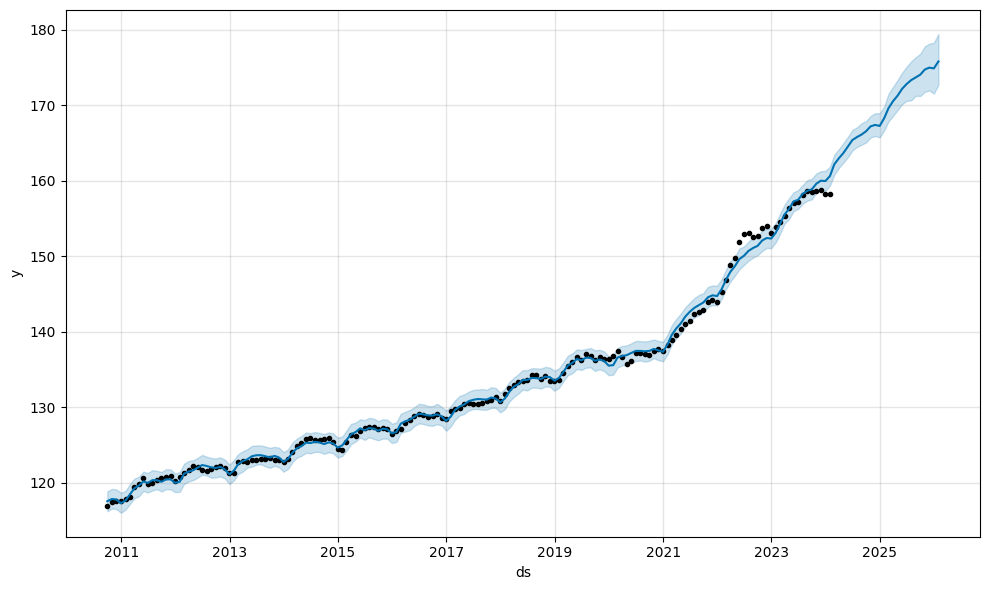

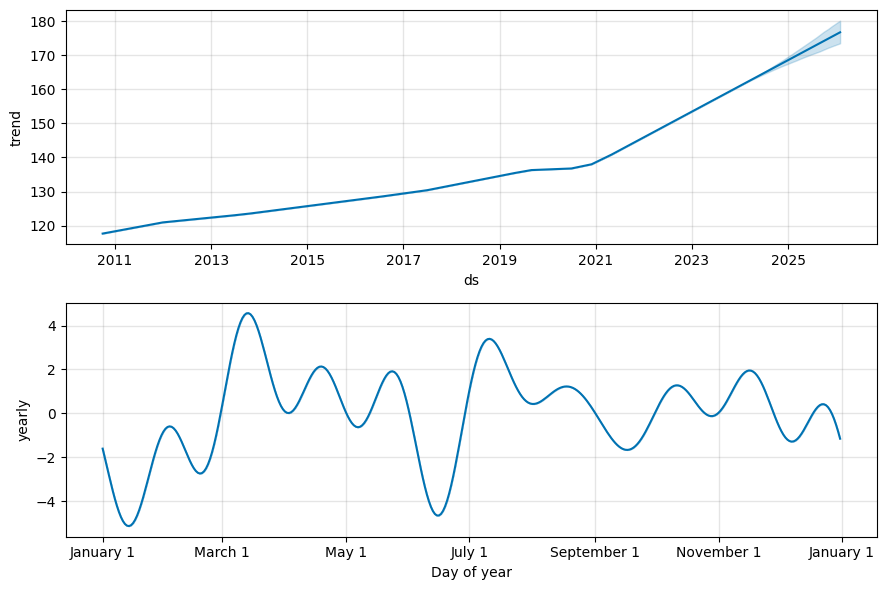

In [3]:
my_model = Prophet(interval_width=0.95,daily_seasonality=False)
my_model.fit(df)

future_dates = my_model.make_future_dataframe(periods=24 , freq = 'ME' , include_history = 'TRUE')
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

fig1 = my_model.plot(forecast)
fig2 = my_model.plot_components(forecast)

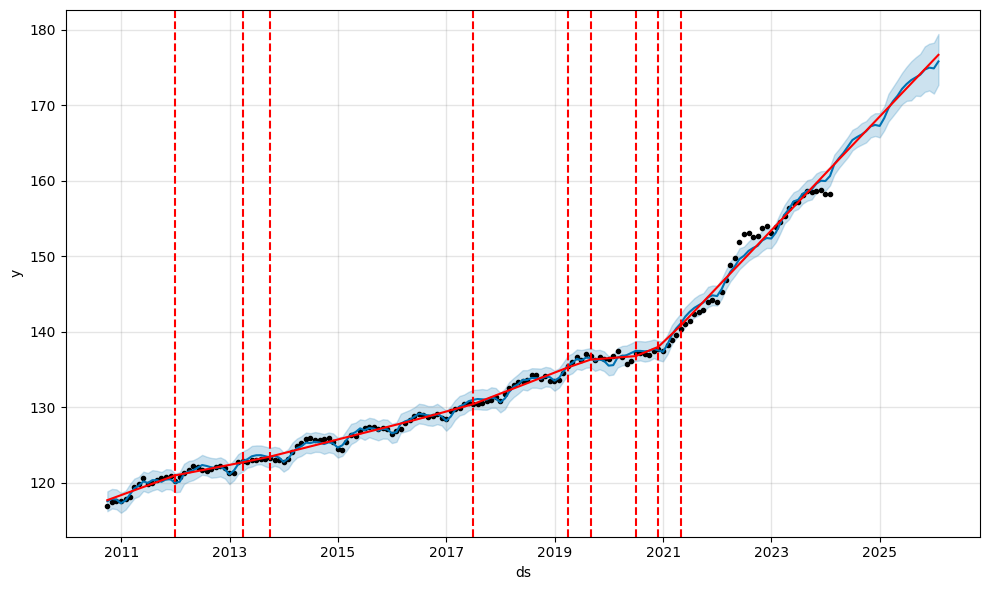

In [4]:
fig = my_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), my_model, forecast)

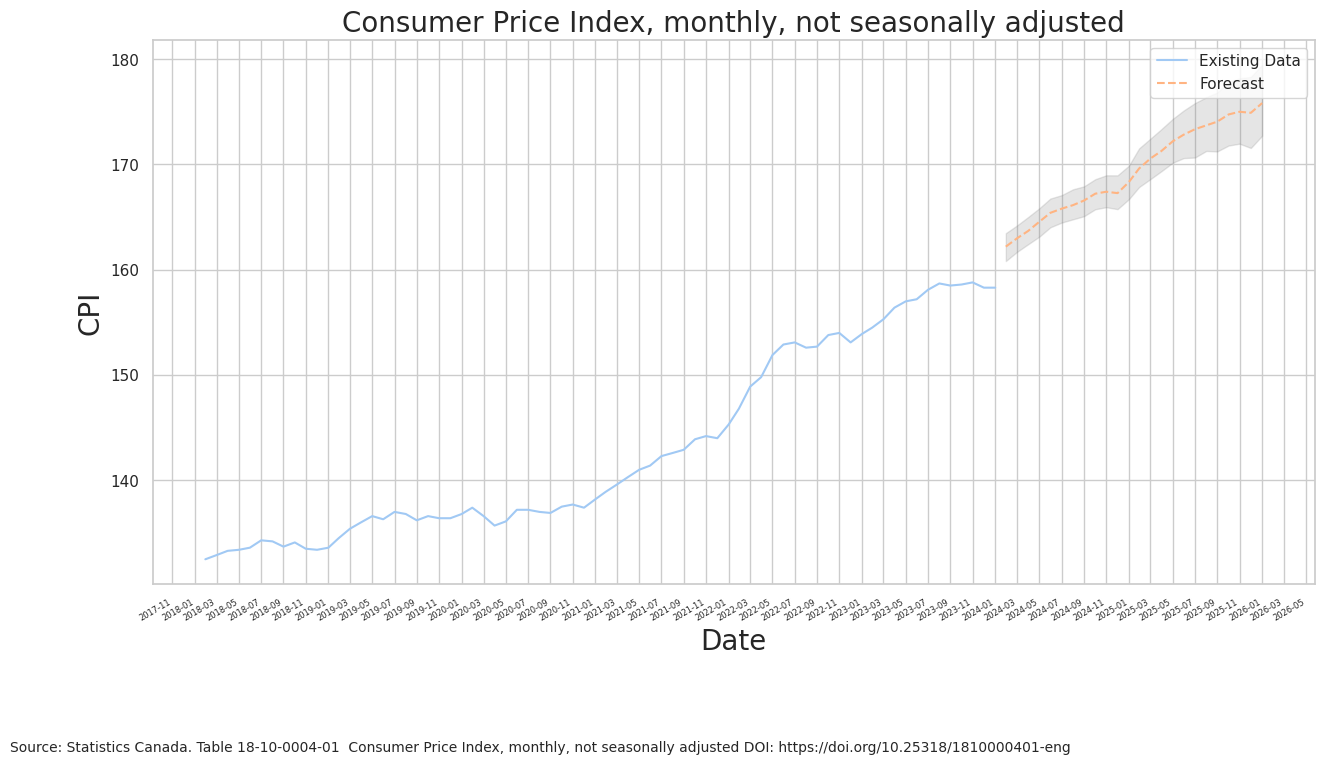

In [5]:
forecast_plot = forecast[(forecast['ds'] > '01/31/2024') ]
forecast_plot = forecast_plot[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

existing_data = df[['ds', 'y']]
existing_data = existing_data[existing_data['ds'] > '01/31/2018']

# Merge the existing data with the forecast on 'ds'
merged_data = pd.merge(existing_data, forecast_plot, on='ds', how='outer')

sns.set(style="whitegrid", font_scale=1)
sns.set_palette("pastel")  # Choose a light color palette

# Plot the existing data
plt.figure(figsize=(15, 8))
sns.lineplot(x='ds', y='y', data=merged_data, label='Existing Data')

# Plot the forecast
sns.lineplot(x='ds', y='yhat', data=merged_data, label='Forecast', linestyle='dashed')

# Fill the confidence interval
plt.fill_between(merged_data['ds'], merged_data['yhat_lower'], merged_data['yhat_upper'], color='gray', alpha=0.2)

# Specify the frequency of the x-axis labels (e.g., every 2 months)
locator = mdates.MonthLocator(bymonthday=-1, interval=2)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate x-axis labels for better readability
plt.gcf().autofmt_xdate()

# Set x-axis label font size
plt.xticks(fontsize=6)

plt.title('Consumer Price Index, monthly, not seasonally adjusted', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('CPI', fontsize=20)
plt.legend()


footnote_text = "Source: Statistics Canada. Table 18-10-0004-01  Consumer Price Index, monthly, not seasonally adjusted DOI: https://doi.org/10.25318/1810000401-eng"
plt.figtext(0.03, -0.01, footnote_text, ha="left", fontsize=10, bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))    

fig.savefig('CPI.png',transparent=True,  bbox_inches='tight',pad_inches=0.15,dpi=400)

plt.show()